In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn modules for TextVectorization and MatrixFactorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split

# Part 1

In [85]:
# load data
df = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

# split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['Category'], test_size=0.2, random_state=42)

# create vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=1000,
    max_df=0.75,
    )
# fit vectorizer to training data
X_train = vectorizer.fit_transform(X_train)
# transform validation data
X_val = vectorizer.transform(X_val)
# transform test data
X_test = vectorizer.transform(df_test['Text'])

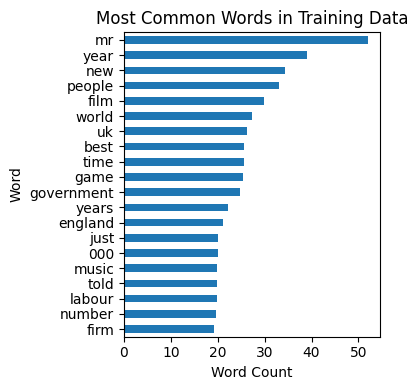

In [86]:
# simple data visualization on training data
# create dataframe from training data
vocab = vectorizer.get_feature_names_out()
df_train = pd.DataFrame(X_train.toarray(), columns=vocab)
# add target column
df_train['Category'] = y_train
# plot bar chart of most common words
plt.figure(figsize=(4, 4))
df_train[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Most Common Words in Training Data')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Word Count')

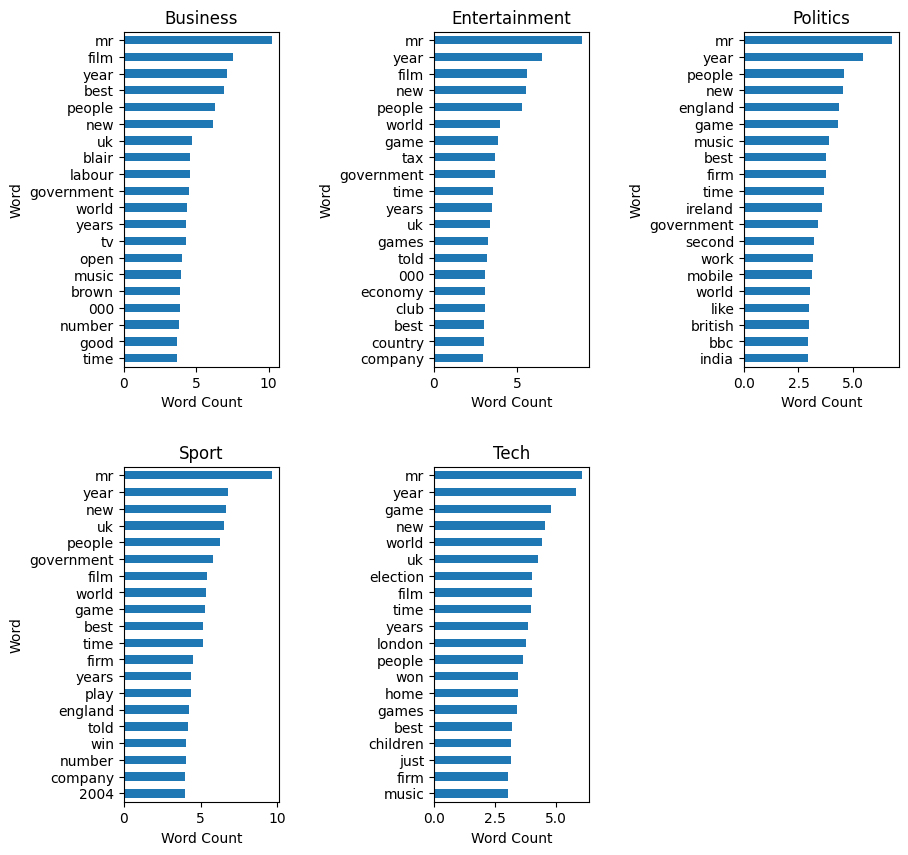

In [87]:
# visualize most common words in each category
# create dataframe for each category
df_train_business = df_train[df_train['Category'] == 'business']
df_train_entertainment = df_train[df_train['Category'] == 'entertainment']
df_train_politics = df_train[df_train['Category'] == 'politics']
df_train_sport = df_train[df_train['Category'] == 'sport']
df_train_tech = df_train[df_train['Category'] == 'tech']

# plot bar chart of most common words in each category
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=1, hspace=0.3)
plt.subplot(2, 3, 1)
df_train_business[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Business')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.subplot(2, 3, 2)
df_train_entertainment[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Entertainment')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.subplot(2, 3, 3)
df_train_politics[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Politics')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.subplot(2, 3, 4)
df_train_sport[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Sport')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.subplot(2, 3, 5)
df_train_tech[vocab].sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Tech')
plt.xlabel('Word Count')


In [129]:
from itertools import permutations
from sklearn.metrics import accuracy_score, mean_squared_error

def label_permute_compare(
        yt,  # y_true series
        yp,  # y_pred list
        metric='accuracy'
    ):
    # Map actual labels to integers if they are not
    unique_labels = yt.unique()
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    yt_mapped = yt.map(label_mapping).to_numpy()

    # Generate all possible label permutations
    n_labels = len(unique_labels)
    label_permutations = permutations(range(n_labels))

    # Initialize variables for the best permutation and its accuracy
    best_permutation = None
    best_accuracy = 0
    best_rmse = 9999999

    # Iterate over all permutations to find the best one
    for perm in label_permutations:
        permuted_labels = [perm[label] for label in yp]
        accuracy = accuracy_score(yt_mapped, permuted_labels)
        rmse = mean_squared_error(yt_mapped, permuted_labels, squared=False)
        if metric == 'accuracy':
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_permutation = perm
        elif metric == 'rmse':
            if rmse < best_rmse:
                best_rmse = rmse
                best_permutation = perm

    # Map the best permutation back to original labels
    if best_permutation is not None:
        best_permutation = [unique_labels[i] for i in best_permutation]

    best_permutation_dict = {i : best_permutation[i] for i in range(len(best_permutation))}

    if metric == 'accuracy':
        return best_permutation_dict, best_accuracy
    elif metric == 'rmse':
        return best_permutation_dict, best_rmse

In [89]:
# create NMF model
nmf = NMF(n_components=len(df['Category'].unique()))

# fit model to training data
nmf.fit(X_train)

# predict on validation data
y_pred = nmf.transform(X_val)

# get the index of the highest value for each row
y_pred = np.argmax(y_pred, axis=1)

# label_permute_compare
best_perm_dict, score =  label_permute_compare(y_val, y_pred)

print(f'Best permutation: {best_perm_dict}')
print(f'Accuracy score: {score}')

Best permutation: {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}
Accuracy score: 0.912751677852349


In [90]:
# predict on test data
y_pred = nmf.transform(X_test)

# get the index of the highest value for each row
y_pred = np.argmax(y_pred, axis=1)

# map predictions to labels
y_pred = [best_perm_dict[i] for i in y_pred]

# create submission dataframe
submission = pd.DataFrame({'ArticleId': df_test['ArticleId'], 'Category': y_pred})

# save submission dataframe
submission.to_csv('submission.csv', index=False)

In [91]:
y_train

1166            sport
1106         business
538          politics
439             sport
1478         politics
            ...      
1130         politics
1294         business
860          politics
1459    entertainment
1126            sport
Name: Category, Length: 1192, dtype: object

In [92]:
# build supervised classification model using lightgbm
import lightgbm as lgb

# make sure target is float or bool
label2num = {label: i for i, label in enumerate(np.unique(y_train))}
num2label = {i: label for label, i in label2num.items()}
y_train = np.array([label2num[label] for label in y_train])
y_val = np.array([label2num[label] for label in y_val])


# create dataset for lightgbm
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
test_data = lgb.Dataset(X_test)

# set parameters
params = {
    'objective': 'multiclass',
    'num_class': len(df['Category'].unique()),
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# train model
model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=1000)

# predict on validation data
y_pred = model.predict(X_val)
# get the index of the highest value for each row
y_pred = np.argmax(y_pred, axis=1)

# get accuracy score
score = accuracy_score(y_val, y_pred)
print(f'Accuracy score: {score}')

Accuracy score: 0.9765100671140939


In [93]:
num2label

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [94]:
# predict on test data
y_pred = model.predict(X_test)

# get the index of the highest value for each row
y_pred = np.argmax(y_pred, axis=1)

# map predictions to labels
y_pred = [num2label[i] for i in y_pred]

# create submission dataframe
submission = pd.DataFrame({'ArticleId': df_test['ArticleId'], 'Category': y_pred})

# save submission dataframe
submission.to_csv('submission_sv.csv', index=False)

In [110]:
'''
Discuss comparison with the unsupervised approach.
You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes).
Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?
'''

def compare_learning_methods(
        X_train, X_val, y_train, y_val,
        train_data_size=0.1
    ):
    # reduce train data size
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=1-train_data_size, random_state=42)

    # create NMF model
    nmf = NMF(n_components=5)

    # fit model to training data
    nmf.fit(X_train)

    # predict on validation data
    y_pred = nmf.transform(X_val)

    # get the index of the highest value for each row
    y_pred = np.argmax(y_pred, axis=1)

    # label_permute_compare
    best_perm_dict, score_nmf =  label_permute_compare(
        pd.Series(y_val, name='Category'),
        y_pred)
    
    _, train_score_nmf =  label_permute_compare(
        pd.Series(y_train, name='Category'),
        np.argmax(nmf.transform(X_train), axis=1))

    print(f'Accuracy score (NMF): {score_nmf}')

    # training lightgbm model
    # create dataset for lightgbm
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # set parameters
    params = {
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1
    }

    # train model
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=1000)

    # predict on validation data
    y_pred = model.predict(X_val)
    # get the index of the highest value for each row
    y_pred = np.argmax(y_pred, axis=1)

    # get accuracy score
    score_lgb = accuracy_score(y_val, y_pred)
    train_score_lgb = accuracy_score(y_train, np.argmax(model.predict(X_train), axis=1))
    print(f'Accuracy score (LGB): {score_lgb}')
    return train_score_nmf, score_nmf, train_score_lgb, score_lgb
    

In [111]:
compare_learning_methods(X_train, X_val, y_train, y_val, train_data_size=0.1)

Accuracy score (NMF): 0.8993288590604027
Accuracy score (LGB): 0.6040268456375839


(0.9327731092436975, 0.8993288590604027, 1.0, 0.6040268456375839)

In [112]:
result = pd.DataFrame(columns=['NMF_train', 'NMF_val', 'LGB_train', 'LGB_val', 'Train Data Size'])

for train_data_size in [0.1, 0.2, 0.5, 0.99]:
    print(f'Train data size: {train_data_size}')
    train_score_nmf, score_nmf, train_score_lgb, score_lgb = compare_learning_methods(X_train, X_val, y_train, y_val, train_data_size=train_data_size)
    print('')
    result = pd.concat([result, pd.DataFrame([[train_score_nmf, score_nmf, train_score_lgb, score_lgb, train_data_size]], columns=result.columns)])

Train data size: 0.1
Accuracy score (NMF): 0.8993288590604027
Accuracy score (LGB): 0.6040268456375839

Train data size: 0.2
Accuracy score (NMF): 0.8959731543624161


/var/folders/_1/_y6lxkm177x0g8qp8xrnnxrh0000gn/T/ipykernel_25296/310197367.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, pd.DataFrame([[train_score_nmf, score_nmf, train_score_lgb, score_lgb, train_data_size]], columns=result.columns)])


Accuracy score (LGB): 0.8557046979865772

Train data size: 0.5
Accuracy score (NMF): 0.9161073825503355
Accuracy score (LGB): 0.9362416107382551

Train data size: 0.99
Accuracy score (NMF): 0.9093959731543624
Accuracy score (LGB): 0.9731543624161074



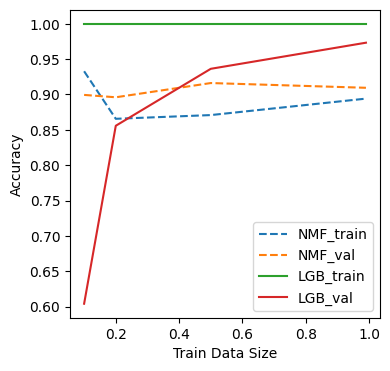

In [116]:
# plot train data size vs. accuracy (train and validation)
plt.figure(figsize=(4, 4))
plt.plot(result['Train Data Size'], result['NMF_train'], label='NMF_train', linestyle='--')
plt.plot(result['Train Data Size'], result['NMF_val'], label='NMF_val', linestyle='--')
plt.plot(result['Train Data Size'], result['LGB_train'], label='LGB_train', linestyle='-')
plt.plot(result['Train Data Size'], result['LGB_val'], label='LGB_val', linestyle='-')
plt.xlabel('Train Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Part 2

In [124]:
'''
1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library.
2. Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?
'''

# load data
df_movie = pd.read_table('movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
df_movie.columns = ['MovieID', 'Title', 'Genres']

df_rating = pd.read_table('ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')
df_rating.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

df_user = pd.read_table('users.dat', sep='::', header=None, engine='python', encoding='latin-1')
df_user.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# integrate data
df = df_rating.merge(df_movie, on='MovieID', how='left')
df = df.merge(df_user, on='UserID', how='left')

# data preprocessing
# Genre column
# split genres by '|'
df['Genres'] = df['Genres'].str.split('|')
# one-hot encode genres
df = df.explode('Genres')
df = pd.get_dummies(df, columns=['Genres'])

# Gender column
# F/M -> 0/1
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Occupation column
# one-hot encode occupation
df = pd.get_dummies(df, columns=['Occupation'])


In [125]:
df.head()

,UserID,MovieID,Rating,Timestamp,Title,Age,Zip-code,Genres_Action,Genres_Adventure,Genres_Animation,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),1,48067,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),1,48067,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),1,48067,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach (1996),1,48067,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady (1964),1,48067,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [126]:
# build matrix factorization model using sklearn
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['UserID', 'MovieID', 'Title', 'Timestamp', 'Zip-code', 'Rating']), df['Rating'], test_size=0.2, random_state=42)

In [127]:
df.Rating.unique()  

array([5, 3, 4, 2, 1])

In [134]:
# create NMF model
nmf = NMF(n_components=5)

# fit model to training data
nmf.fit(X_train)

# predict on test data
y_pred = nmf.transform(X_test)

# get the index of the highest value for each row
y_pred = np.argmax(y_pred, axis=1)

# evaluate rmse
_, rmse = label_permute_compare(y_test, y_pred, metric='rmse')

print(f'RMSE: {rmse}')

RMSE: 1.3461481224125291


In [133]:
# build baseline model
# calculate mean rating
mean_rating = y_train.mean()

# predict mean rating for each row
y_pred = np.full(len(y_test), mean_rating)

# evaluate rmse
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 1.1173352254548026


Non-negative matrix factorization might not perform as well as a simple baseline in some scenarios due to various factors like the complexity of the data, the choice of parameters, or the nature of the algorithm itself. NMF is sensitive to the initial values and often requires careful tuning of parameters like the number of components. Additionally, NMF may struggle with very sparse matrices or datasets where the underlying structure doesn't align well with the assumptions of the NMF model.